In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import sep 
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

#### Check package versions, to ensure they are up to date

In [2]:
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.1
1.1.1


# Take separate HSC images in g,r,i bands, and combine into one usable multiband image 

#### Note: deepCoadd calexp deepCoadd/$(filter)/$(tract)/$(patch)/calexp-$(filter)-$(tract)-$(patch).fits

The format of hsc data folders are as follows:

_det_: List of source positions and footprints detected on a coadd patch. (FITS BINTABLE)

_warp_: Image of a single visit (CORR) transformed onto a destination tangential plane in a tract. (Multi-extension FITS IMAGE + BINTABLE)

_calexp_: Coadd image in a single band, or resultant image from the Stack stage, which combines all the overlapped warp images. (Multi-extension FITS IMAGE + BINTABLE)

In [3]:
channels_hsc = ['G', 'R', 'I']
n = []

for channel in channels_hsc:
    obs_hdul = fits.open(f'../../HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-{channel}/10054/0,0/calexp-HSC-{channel}-10054-0,0.fits.gz')
    data_hdu = obs_hdul[1].data
    wcs_hdu = WCS(obs_hdul[1].header)
    
    data_cut = Cutout2D(data_hdu, position=[50, 50], size=[200,200], wcs=wcs_hdu)
    n.append(data_cut.data)
    
n = np.array(n)    
obs_hdu = fits.PrimaryHDU(n)
print(data_cut)

### Display Image Cube

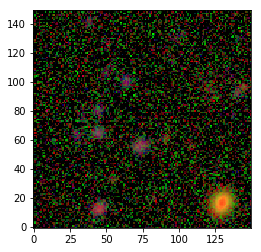

(150, 150, 3)


In [4]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(n, norm=norm) 
plt.imshow(img_rgb)
plt.show()

print(img_rgb.shape) #channels, height, width

#### scarlet Frames require images in (channels, height, width) order, so swap axes

In [5]:
#swap_img_rgb = np.swapaxes(img_rgb,0,2)
#print(swap_img_rgb.shape) #channels, height, width

swap_img_rgb = np.zeros([3, 150, 150])
swap_img_rgb[0,:,:] = img_rgb[:,:,0]
swap_img_rgb[1,:,:] = img_rgb[:,:,1]
swap_img_rgb[2,:,:] = img_rgb[:,:,2]


print(swap_img_rgb.shape)

(3, 150, 150)


## Define Model Frame and Observation

A `Frame` in *scarlet* is a description of the hyperspectral cube of the model or the observations. Think of it as the metadata, what aspects of the sky are described here. At the least, a `Frame` holds the `shape` of the cube, for which we use the convention `(C, Ny, Nx)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `Ny, Nx` for the number of pixels at every channel.

An `Observation` combines a `Frame` with several data units, similar to header-data arrangement in FITS files. In addition to the actual science image cube, you can and often must provide weights for all elements in the data cube, an image cube of the PSF model (one image for all or one for each channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

In [6]:
# Model

model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(channels_hsc))

model_frame = scarlet.Frame(
    swap_img_rgb.shape,
    #wcs=wcs_hsc,
    psf=model_psf,
    channels=channels_hsc) 

In [7]:
# HSC observation frame from data

observation = scarlet.Observation(
    swap_img_rgb,
    #wcs=wcs_hsc,
    psf= scarlet.GaussianPSF(sigma=(0.6,)*len(channels_hsc)),
    weights=None, 
    channels=channels_hsc).match(model_frame)

# Build detection catalog to get centers, weights, etc.

In [8]:
# Here is original
"""
def makeCatalog(obs_lr, obs_hr, lvl = 3, wave = True):
    # Create a catalog of detected source by running SEP on the wavelet transform 
    # of the sum of the high resolution images and the low resolution images interpolated to the high resolution grid
    #Interpolate LR to HR
    interp = scarlet.interpolation.interpolate_observation(obs_lr, obs_hr)
    # Normalisation 
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    hr_images = obs_hr.data/np.sum(obs_hr.data, axis = (1,2))[:,None, None]
    # Summation to create a detection image
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= np.sum(obs_hr.data)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, lvl=lvl, direct = False).coefficients[0]
    
    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
    for img in [obs_lr.data, obs_hr.data]:
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
        
    return catalog, bg_rms, detect_image
"""

# my modification

# In ~/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/scarlet/renderer.py
# change np.int() to int() --> not supported in numpy 1.20.1, depreciation throws error

# In ~/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/scarlet/wavelet.py
# change np.int() to int() not supported in numpy 1.20.1, depreciation throws error
        
obs_hsc = observation    
    
def makeCatalog(obs_hr, lvl = 3, wave = True):
    hr_images = obs_hr.data/np.sum(obs_hr.data, axis = (1,2))[:,None, None]
    # Summation to create a detection image
    #detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    detect_image = np.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= np.sum(obs_hr.data)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, direct = False).coefficients[0]
    
    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
        #print(detect)
    else:
        detect = detect_image
        print(detect)
        
        # Runs SEP detection
    #detect = detect_image
    #print(detect.flags) # C_CONTIGUOUS : False throws ValueError: array is not C-contiguous
    detect = detect_image.copy(order='C')
    
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
    for img in obs_hr.data:
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img.copy(order='C')).globalrms) #same C-order issue
        
    return catalog, bg_rms, detect_image

# Making catalog. 
# With the wavelet option on, only the first 3 wavelet levels are used for detection. Set to 1 for better detection
wave = 1
lvl = 3
catalog_hsc, (bg_hsc), detect = makeCatalog(obs_hsc, lvl, wave)

# we can now set the empirical noise rms for both observations
obs_hsc.weights = np.ones(obs_hsc.shape) / (np.array(bg_hsc)**2)[:, None, None]  #make array!


print(bg_hsc) # SHOULD NOT BE ALL 1's!
print(obs_hsc.weights)
print(catalog_hsc)
print(detect)

[1.0, 0.045314595103263855, 1.0]
[[[  1.           1.           1.         ...   1.           1.
     1.        ]
  [  1.           1.           1.         ...   1.           1.
     1.        ]
  [  1.           1.           1.         ...   1.           1.
     1.        ]
  ...
  [  1.           1.           1.         ...   1.           1.
     1.        ]
  [  1.           1.           1.         ...   1.           1.
     1.        ]
  [  1.           1.           1.         ...   1.           1.
     1.        ]]

 [[486.99420389 486.99420389 486.99420389 ... 486.99420389 486.99420389
   486.99420389]
  [486.99420389 486.99420389 486.99420389 ... 486.99420389 486.99420389
   486.99420389]
  [486.99420389 486.99420389 486.99420389 ... 486.99420389 486.99420389
   486.99420389]
  ...
  [486.99420389 486.99420389 486.99420389 ... 486.99420389 486.99420389
   486.99420389]
  [486.99420389 486.99420389 486.99420389 ... 486.99420389 486.99420389
   486.99420389]
  [486.99420389 486.99

/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


#### We can now make use of the convenience function `scarlet.display.show_observation` to plot observations as RGB images, with individual sources labeled at their position on the sky. It can also show the PSF in the same scaling.

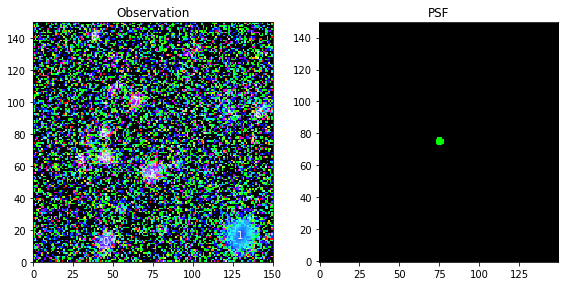

In [9]:
# Create a color mapping for the HSC image

# Get the source coordinates from the HST catalog
pixel_hsc = np.stack((catalog_hsc['y'], catalog_hsc['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec = obs_hsc.get_sky_coord(pixel_hsc)

scarlet.display.show_observation(observation, norm=norm, sky_coords=ra_dec, show_psf=True)
plt.show()

In [10]:
centers = ra_dec
centers

array([[ 12.70325101,  45.15398713],
       [ 16.66479093, 129.51558317],
       [ 55.76139785,  73.82313429],
       [ 63.74073366,  29.80490726],
       [ 65.10084191,  44.61628835],
       [ 80.46927311,  44.29348507],
       [ 92.6594221 , 140.31145007],
       [100.30670541,  63.93513811],
       [141.53806197,  38.08356068]])

In [11]:
sources, skipped = scarlet.initialization.init_all_sources(model_frame, 
                                                           centers, 
                                                           observation, 
                                                           max_components=2, 
                                                           min_snr=50,
                                                           thresh=1,
                                                           fallback=True,
                                                           silent=True,
                                                           set_spectra=True
                                                          )

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")

Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2
Failed to initialize source 3
Failed to initialize source 4
Failed to initialize source 5
Failed to initialize source 6
Failed to initialize source 7
Failed to initialize source 8


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

# Create and Fit Model here